In [1]:
import numpy as np
import matplotlib.pyplot as plt

### With this code I do the numerical simulation for the tent map and upside-down tent map in combination with heterogeneous expectations. It also gives multiple graphs which can be used to give information about the dynamics.

In [2]:
# Define the asymmetric tent map
def tent_map_scalar(x, beta):
    if x <= (1 + beta) / 2 and x >= 0:
        return 2 * x / (1 + beta)
    elif x > (1 + beta) / 2 and x <= 1:
        return 2 * (1 - x) / (1 - beta)
    elif x < 0:
        return 0
    else:
        return 1

def tent_map_scalar_ud(x, beta):
    return 1 - tent_map_scalar(x, beta)

def naive_learning_forecast(x, t):
    return x[t - 2]

def learning_by_average_forecast(x, t):
    x_known = x[:(t - 1)]
    return np.mean(x_known)

def trend_extrapolating_learning_forecast(x, t, g):
    forecast = x[t - 2] + g*(x[t - 2] - x[t - 3])
    if forecast > 1:
        forecast = 1
    elif forecast < 0:
        forecast = 0
    return forecast

def adaptive_learning_forecast(x, forecast_vals, t, l):
    forecast = forecast_vals[t - 2] + l*(x[t - 2] - forecast_vals[t - 2])
    return forecast

def SAC_learning_forecast(x, a, b, t):
    forecast = a[t - 2] + b[t - 2]**2 * (x[t - 2] - a[t - 2])
    return forecast

def SAC_learning_update(x, a, b, r, t):
    r[t] = r[t - 1] + (t / (t + 1) * (x[t] - a[t - 1])**2 - r[t - 1]) / (t + 1)
    a[t] = a[t - 1] + (x[t] - a[t - 1]) / (t + 1)
    b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])
    return a, b, r

In [4]:
# Initial beliefs
x0 = 0.5

# Model parameters
g_trend = 0.4
g_contr = -0.4
l = 0.65
gamma = 0.4
beta = -0.25
eta = 0.7
delta = 0.9
tent="tent"

# Learning rule indices
NAIVE, LBA, TRE, CONTR, ADA, SAC = 0, 1, 2, 3, 4, 5
num_rules = 6

# Simulate the system under heterogeneous learning
def simulate_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=500, burn_in=0, print=True):
    x_vals = np.zeros(T)
    x_vals[0] = x0

    n = np.full((T, num_rules), 1/num_rules)
    x_expect = np.zeros((T + 1, num_rules))
    U = np.zeros(num_rules)

    for i in range(num_rules):
        x_expect[0, i] = x0
        x_expect[1, i] = x0

    a = np.zeros(T)
    b = np.zeros(T)
    r = np.zeros(T)
    a[0] = x0
    
    if tent=="tent":
        for t in range(1, T):
            x_expect[t + 1, NAIVE] = naive_learning_forecast(x_vals, t + 1)
            x_expect[t + 1, LBA] = learning_by_average_forecast(x_vals, t + 1)
            x_expect[t + 1, TRE] = trend_extrapolating_learning_forecast(x_vals, t + 1, g_trend)
            x_expect[t + 1, CONTR] = trend_extrapolating_learning_forecast(x_vals, t + 1, g_contr)
            x_expect[t + 1, ADA] = adaptive_learning_forecast(x_vals, x_expect[:, ADA], t + 1, l)
            x_expect[t + 1, SAC] = SAC_learning_forecast(x_vals, a, b, t + 1)

            pi = - (x_vals[t - 1] - x_expect[t - 1, :])**2
            U = pi + eta*U
            exp_U = np.exp(gamma * U)
            n[t] = delta*n[t - 1] + (1 - delta)*exp_U / exp_U.sum()
            
            aggregate_expectation = np.dot(n[t], x_expect[t + 1])
            x_vals[t] = tent_map_scalar(aggregate_expectation, beta)

            a, b, r = SAC_learning_update(x_vals, a, b, r, t)
            

    elif tent=="tent_ud":
        for t in range(1, T):
            x_expect[t + 1, NAIVE] = naive_learning_forecast(x_vals, t + 1)
            x_expect[t + 1, LBA] = learning_by_average_forecast(x_vals, t + 1)
            x_expect[t + 1, TRE] = trend_extrapolating_learning_forecast(x_vals, t + 1, g_trend)
            x_expect[t + 1, CONTR] = trend_extrapolating_learning_forecast(x_vals, t + 1, g_contr)
            x_expect[t + 1, ADA] = adaptive_learning_forecast(x_vals, x_expect[:, ADA], t + 1, l)
            x_expect[t + 1, SAC] = SAC_learning_forecast(x_vals, a, b, t + 1)

            pi = - (x_vals[t - 1] - x_expect[t - 1, :])**2
            U = pi + eta*U
            exp_U = np.exp(gamma * U)
            n[t] = delta*n[t - 1] + (1 - delta)*exp_U / exp_U.sum()
            
            aggregate_expectation = np.dot(n[t], x_expect[t + 1])
            x_vals[t] = tent_map_scalar_ud(aggregate_expectation, beta)

            a, b, r = SAC_learning_update(x_vals, a, b, r, t)

    if print==True:
        labels = ["Naïve", "Average", "Trend", "Contrarian", "Adaptive", "SAC"]
        
        # Plot 1: Dynamics
        plt.figure(figsize=(8, 4))
        plt.plot(x_vals, color='black')
        plt.title('Dynamics under Heterogeneous Expectations')
        plt.xlabel('Time')
        plt.tight_layout()
        if tent=="tent":
            plt.savefig("Images/dynamics_heterogeneous_learning.png", dpi=300)
        else:
            plt.savefig("Images/dynamics_heterogeneous_learning_ud.png", dpi=300)
        plt.show()
        
        # Plot 2: Learner Fractions
        plt.figure(figsize=(8, 4))
        for i in range(num_rules):
            plt.plot(n[:, i], label=f'{labels[i]} Expectations')
        plt.title('Fractions of Expectation Types')
        plt.xlabel('Time')
        plt.legend()
        plt.tight_layout()
        if tent=="tent":
            plt.savefig("Images/fractions_heterogeneous_learning.png", dpi=300)
        else:
            plt.savefig("Images/fractions_heterogeneous_learning_ud.png", dpi=300)
        plt.show()
    
        # Plot 3: Expectations
        plt.figure(figsize=(8, 4))
        for i in range(num_rules):
            plt.plot(x_expect[:, i], label=f'{labels[i]} Expectations')
        plt.title('Expectation Dynamics')
        plt.xlabel('Time')
        plt.legend()
        plt.tight_layout()
        if tent=="tent":
            plt.savefig("Images/expectations_heterogeneous_learning.png", dpi=300)
        else:
            plt.savefig("Images/expectations_heterogeneous_learning_ud.png", dpi=300)
        plt.show()
    else:
        return x_vals[burn_in:], n[burn_in:]

simulate_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=50)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_52988\1208162867.py:41: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


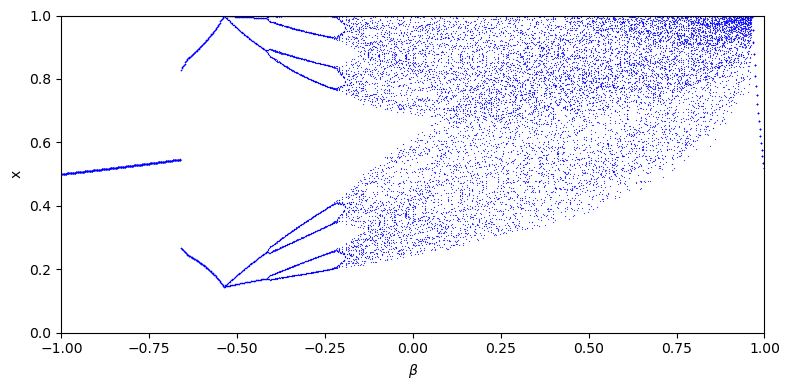

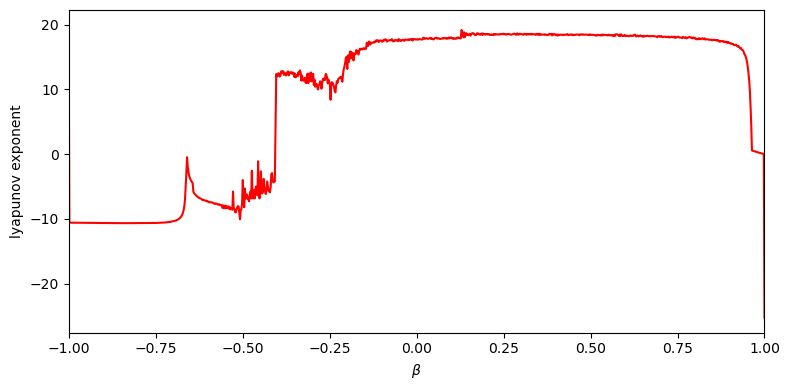

In [8]:
# Initial beliefs
x0 = 0.5

# Model parameters
g_trend = 0.4
g_contr = -0.4
l = 0.65
gamma = 0.4
eta = 0.7
delta = 0.9
tent="tent"

n_skip = 2000
n_iter = 20

# Learning rule indices
NAIVE, LBA, TRE, CONTR, ADA, SAC = 0, 1, 2, 3, 4, 5
num_rules = 6

def lyapunov_exponent_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=2000, burn_in=0, eps=1e-9):
    x_base = simulate_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=T, burn_in=burn_in, print=False)[0]
    x_pert = simulate_heterogeneous_learning(beta, x0+ eps, g_trend, g_contr, l, gamma, eta, delta, tent, T=T, burn_in=burn_in, print=False)[0]
    dist = np.abs(x_pert - x_base) + 1e-20
    return np.log(dist[burn_in:] / eps).mean()

def orbit_and_lyapunov_heterogeneous_learning(seed, g_trend, g_contr, l, gamma, eta, delta, n_skip, n_iter, tent, step=0.001):
    beta_range = np.linspace(-1, 1, int(1/step))
    lyap = []
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for beta in beta_range:
        x_vals = simulate_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=n_iter + n_skip, burn_in=n_skip, print=False)[0]
        ax1.scatter(np.full_like(x_vals, beta), x_vals, s=0.75, color='blue', alpha=0.8, linewidths=0)
        lyap.append(lyapunov_exponent_heterogeneous_learning(beta, seed, g_trend, g_contr, l, gamma, eta, delta, tent))
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel('x')
    plt.tight_layout()
    if tent=="tent":
        plt.savefig("Images/heterogeneous_learning_orbit_diagram.png", dpi=300)
    elif tent=="tent_ud":
        plt.savefig("Images/heterogeneous_learning_orbit_diagram_ud.png", dpi=300)
    plt.show()
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(beta_range, lyap, color='red')
    ax2.set_xlim(-1, 1)
    ax2.set_xlabel(r'$\beta$')
    ax2.set_ylabel('lyapunov exponent')
    plt.tight_layout()
    if tent == "tent":
        plt.savefig("Images/heterogeneous_learning_lyapunov.png")
    else:
        plt.savefig("Images/heterogeneous_learning_lyapunov_ud.png")
    plt.show()

orbit_and_lyapunov_heterogeneous_learning(x0, g_trend, g_contr, l, gamma, eta, delta, n_skip, n_iter, tent)

In [ ]:
# Initial beliefs
x0 = 0.5

# Model parameters
g_trend = 0.4
g_contr = -0.4
l = 0.65
gamma = 0.4
eta = 0.7
delta = 0.9
tent="tent"
n_skip = 2000
n_iter=1

# Learning rule indices
NAIVE, LBA, TRE, CONTR, ADA, SAC = 0, 1, 2, 3, 4, 5
num_rules = 6


def orbit_heterogeneous_learning_rules(seed, g_trend, g_contr, l, gamma, eta, delta, n_skip, n_iter, tent, step=0.005):
    beta_range = np.linspace(-1, 1, int(1/step))
    labels = ["Naïve", "Average", "Trend", "Contrarian", "Adaptive", "SAC"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",  "tab:purple", "tab:brown"]
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for beta in beta_range:
        n_vals = simulate_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=n_iter + n_skip, burn_in=n_skip, print=False)[1]
        for i in range(len(labels)):
            ax1.scatter(np.full_like(n_vals[:,i], beta), n_vals[:,i], s=4, alpha=0.75, color=colors[i], label=labels[i] if beta == beta_range[0] else None)

    ax1.set_xlim(-1, 1)
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel('Fraction of learners')
    ax1.legend(title="Learning rule", loc='lower right', frameon=False, fontsize=9)
    plt.tight_layout()
    if tent=="tent":
        plt.savefig("Images/heterogeneous_learning_rules_orbit_diagram.png", dpi=300)
    elif tent=="tent_ud":
        plt.savefig("Images/heterogeneous_learning_rules_orbit_diagram_ud.png", dpi=300)
    plt.show()

orbit_heterogeneous_learning_rules(x0, g_trend, g_contr, l, gamma, eta, delta, n_skip, n_iter, tent)

### Now we go over to the upside-down tent map, again in combination with heterogeneous expectations

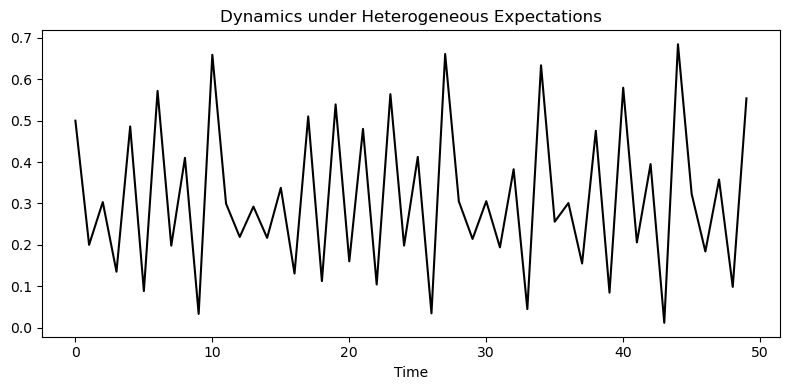

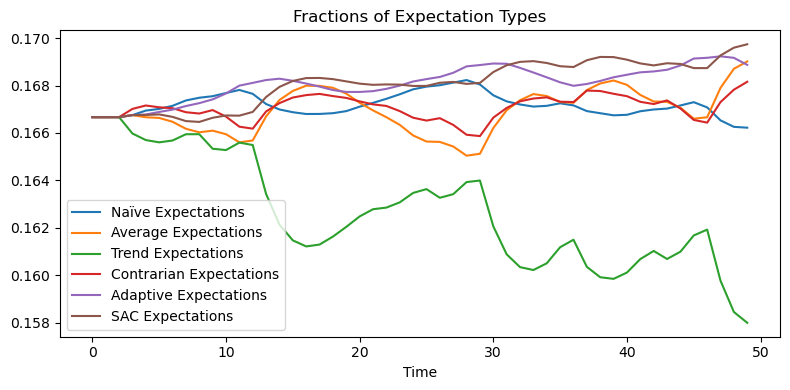

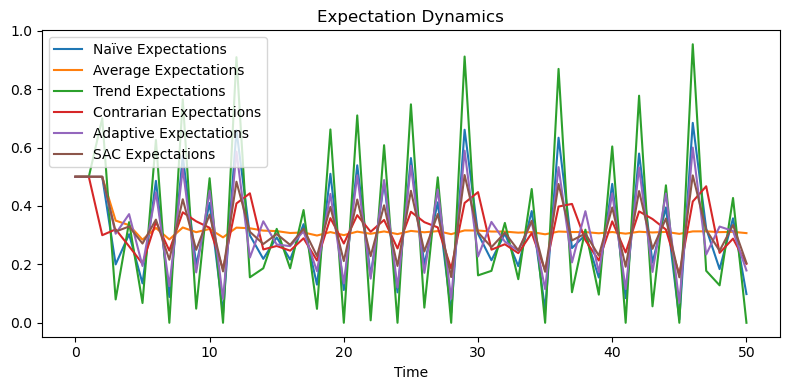

In [120]:
# Initial beliefs
x0 = 0.5

# Model parameters
g_trend = 0.4
g_contr = -0.4
l = 0.65
gamma = 0.4
beta = -0.25
eta = 0.7
delta = 0.9
tent="tent_ud"

# Learning rule indices
NAIVE, LBA, TRE, CONTR, ADA, SAC = 0, 1, 2, 3, 4, 5
num_rules = 6

simulate_heterogeneous_learning(beta, x0, g_trend, g_contr, l, gamma, eta, delta, tent, T=50)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_52988\1208162867.py:41: RuntimeWarning: invalid value encountered in scalar divide
  b[t] = b[t - 1] + ((x[t] - a[t - 1])*(x[t - 1] + x[0] / (t + 1) - ((t**2 + 3*t + 1) / (t + 1)**2) * a[t - 1] - x[t] / (t + 1)**2) - t * b[t - 1] * (x[t] - a[t - 1])**2 / (t + 1)) / ((t + 1) * r[t])


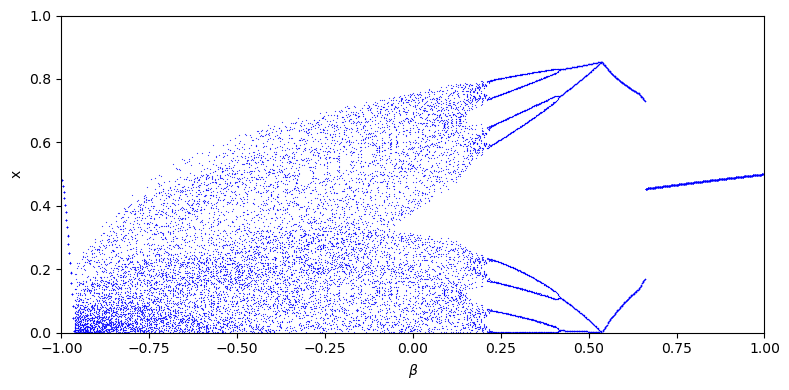

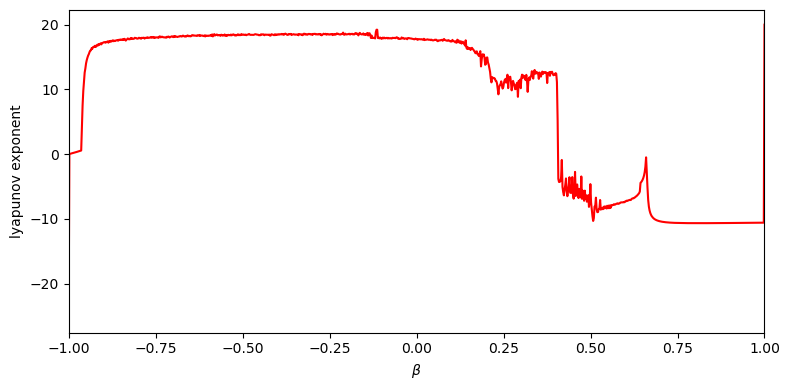

In [10]:
n_skip = 2000
n_iter = 20

orbit_and_lyapunov_heterogeneous_learning(x0, g_trend, g_contr, l, gamma, eta, delta, n_skip, n_iter, tent="tent_ud")

In [ ]:
orbit_heterogeneous_learning_rules(x0, g_trend, g_contr, l, gamma, eta, delta, n_skip, n_iter, tent="tent_ud")